# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter


# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import entropy
from sklearn.model_selection import GridSearchCV

# MLP
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Model Processing
from sklearn.dummy import DummyClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imblearnPipeline
from sklearn.preprocessing import PowerTransformer

from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN

# Functions

In [5]:
def spot_check_models(X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded):
    """
    This a quick way to spot check relevant algorithms to gain an understanding of 
    the dataset and which models handle the distribution well.

    Args:
        X_train_scaled (_type_): _description_
        X_test_scaled (_type_): _description_
        y_train_encoded (_type_): _description_
        y_test_encoded (_type_): _description_

    Returns:
        _type_: Sorted dataframe on accuracy scores.
    """
    models = {
        
        "GaussianNB": GaussianNB(),
        "LDA":LinearDiscriminantAnalysis(),
        "GPC":GaussianProcessClassifier(),
        
        "LogisticRegression": LogisticRegression(),
        "SVC": SVC(),
        "KNeighborsClassifier": KNeighborsClassifier(),
        
        "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
        "RandomForestClassifier": RandomForestClassifier(random_state=42),
        "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42),
        "XGB":XGBClassifier()
    }

    # Create an empty DataFrame to store model performance
    model_performance = []

    for name, model in models.items():
        model.fit(X_train_scaled, y_train_encoded)
        predictions = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test_encoded, predictions)
        model_performance.append({
            "Model": name,
            "Accuracy": accuracy
        })

    # For the Sequential model
    sequential_model = Sequential()
    sequential_model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    sequential_model.add(Dense(32, activation='relu'))
    sequential_model.add(Dense(1, activation='sigmoid'))
    sequential_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    sequential_model.fit(X_train_scaled, y_train_encoded, epochs=50, batch_size=10, verbose=0)
    loss, accuracy = sequential_model.evaluate(X_test_scaled, y_test_encoded)
    model_performance.append({
        "Model": "Sequential",
        "Accuracy": accuracy
    })

    # Convert the model_performance to a DataFrame
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Accuracy", ascending=False)


def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier()
  }
  
  return [models[model] for model in names]

def f2_measure(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  
  metric = make_scorer(f2_measure)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

def labels_to_probabilities(y):
    values, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return probabilities

def calculate_entropy(df:pd.DataFrame)-> pd.DataFrame:
  """_summary_

  Args:
      df (pd.DataFrame): Pandas DataFrame

  Returns:
      pd.DataFrame: THe Entropy level of all models
  """

  column_entropy_info = {}
  for col in df.columns:
    probabilities = labels_to_probabilities(df[col])
    entropy_value = entropy(probabilities, base=2)
    column_entropy_info[col] = {
          'entropy': entropy_value
      }

  return pd.DataFrame(column_entropy_info)

def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    
    for i in range(len(models)):
        pipeline = Pipeline(steps=[('scaler', StandardScaler()), ("power_tranformer",PowerTransformer()), ('model', models[i])])
        # Evaluate the model
        scores = evaluate_model(X, y, pipeline)
        # summarize and store
        print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

def grid_search_selected_models(param_grid:dict,names:list, models:list, X:pd.DataFrame, y:pd.Series, metric):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    model_performance = []

    for i in range(len(models)):
        model, name = models[i], names[i]
        pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('power_transformer', PowerTransformer()),
                ('model', model)
        ])
            
        grid_search = GridSearchCV(pipeline, param_grid[name], cv=5, scoring=metric, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
            
        # Predict on the test set
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        f2 = f2_measure(y_test, y_pred)
            
        print(f'Best score for {name}: {grid_search.best_score_:.3f}')
        print("Best parameters:", grid_search.best_params_)
        
        print(f'Test accuracy for {name}: {accuracy:.3f}')
        print(f"F2 Score: {f2:.3f}")
        print("---------------------------------------------------------------")
        
        conf_mat = confusion_matrix(y_test, y_pred)
        # Plot the confusion matrix
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix for {names[i]}')
        plt.show()
            
        model_performance.append({
                "Model": name,
                "Best CV Score": grid_search.best_score_,
                "Test Accuracy": accuracy,
                'F2 Score':f2,
                "Best Parameters": grid_search.best_params_
        })


    model_performance_df = pd.DataFrame(model_performance)
    print(model_performance_df)
    
def get_under_over_sampling_models(names:list):
    """
        Returns list of under sampling models

        Args:
            names (list): _description_
    """
        
    models = {
        "SMOTE": SMOTE(),
        "BLS": BorderlineSMOTE(),
        "ADA": ADASYN(),
        "TL":TomekLinks(),
        "SMOTE-TOMEK": SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')),
        "SMOTE + KKN":SMOTEENN()
    }  
    return [models[model] for model in names]

def test_selected_sampling_models(names:list, models:list, X:pd.DataFrame, y:pd.Series, model):
    """
    Test best model on multiple sampling subsets

    Args:
        names (list): _description_
        models (list): _description_
        X (pd.DataFrame): _description_
        y (pd.Series): _description_
        metric (_type_): _description_
        model (_type_): _description_
    """

    for i in range(len(models)):
        pipeline = imblearnPipeline(steps=[
            ('scaler', StandardScaler()), 
            ("power_tranformer",PowerTransformer()), 
            ('sampling', models[i]),
            ("model", model)
            ])
        # Evaluate the model
        scores = evaluate_model(X, y, pipeline)
        # summarize and store
        print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

def test_final_model(X,y, names, models, final_model):
    """_summary_

    Args:
        X (_type_): _description_
        y (_type_): _description_
        names (_type_): _description_
        model (_type_): _description_
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    model_performance = []

    for i in range(len(models)):
        model, name = models[i], names[i]
        pipeline = imblearnPipeline(steps=[
            ('scaler', StandardScaler()), 
            ("power_tranformer",PowerTransformer()), 
            ('sampling', models[i]),
            ("model", final_model)
            ])
        
        pipeline.fit(X_train, y_train)
        # Predict on the test set
        y_pred = pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        f2 = f2_measure(y_test, y_pred)
        
        print(f'Test accuracy for {name}: {accuracy:.3f}')
        print(f"F2 Score: {f2:.3f}")
        print("---------------------------------------------------------------")
        
        conf_mat = confusion_matrix(y_test, y_pred)
        # Plot the confusion matrix
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix for {names[i]}')
        plt.show()
            
        model_performance.append({
                "Model": name,
                "Test Accuracy": accuracy,
                'F2 Score':f2,
        })


    model_performance_df = pd.DataFrame(model_performance)
    print(model_performance_df)

# EDA Analysis

In [7]:
df = pd.read_csv("heart_statlog_cleveland_hungary_final.csv")
df

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1185,45,1,1,110,264,0,0,132,0,1.2,2,1
1186,68,1,4,144,193,1,0,141,0,3.4,2,1
1187,57,1,4,130,131,0,0,115,1,1.2,2,1
1188,57,0,2,130,236,0,2,174,0,0.0,2,1


# Check for Dupe values

In [10]:
print(f"Total Null values: {df.isna().sum()}")
print(f"Total number of duplicate values: {df.duplicated().sum()}")

Total Null values: age                    0
sex                    0
chest pain type        0
resting bp s           0
cholesterol            0
fasting blood sugar    0
resting ecg            0
max heart rate         0
exercise angina        0
oldpeak                0
ST slope               0
target                 0
dtype: int64
Total number of duplicate values: 272


In [11]:
df.drop_duplicates(inplace=True)

In [12]:
df.describe()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,0.789760,3.251634,132.396514,198.799564,0.233115,0.603486,136.809368,0.404139,0.887364,1.636166,0.553377
std,9.432617,0.407701,0.931031,18.514154,109.384145,0.423046,0.805968,25.460334,0.490992,1.066570,0.609341,0.497414
min,28.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000,0.000000
25%,47.000000,1.000000,3.000000,120.000000,173.250000,0.000000,0.000000,120.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,223.000000,0.000000,0.000000,138.000000,0.000000,0.600000,2.000000,1.000000
75%,60.000000,1.000000,4.000000,140.000000,267.000000,0.000000,1.000000,156.000000,1.000000,1.500000,2.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,1.000000


# Check for class imbalance

In [14]:
target = df.values[:,-1]
counter = Counter(target)

for k,v in counter.items():
  per = v/len(target) * 100
  print("Class=%d, Count=%d, Percentage=%.3f%%" % (k,v,per))

Class=0, Count=410, Percentage=44.662%
Class=1, Count=508, Percentage=55.338%


In [15]:
df.dtypes

age                      int64
sex                      int64
chest pain type          int64
resting bp s             int64
cholesterol              int64
fasting blood sugar      int64
resting ecg              int64
max heart rate           int64
exercise angina          int64
oldpeak                float64
ST slope                 int64
target                   int64
dtype: object

# Visuals

<Axes: >

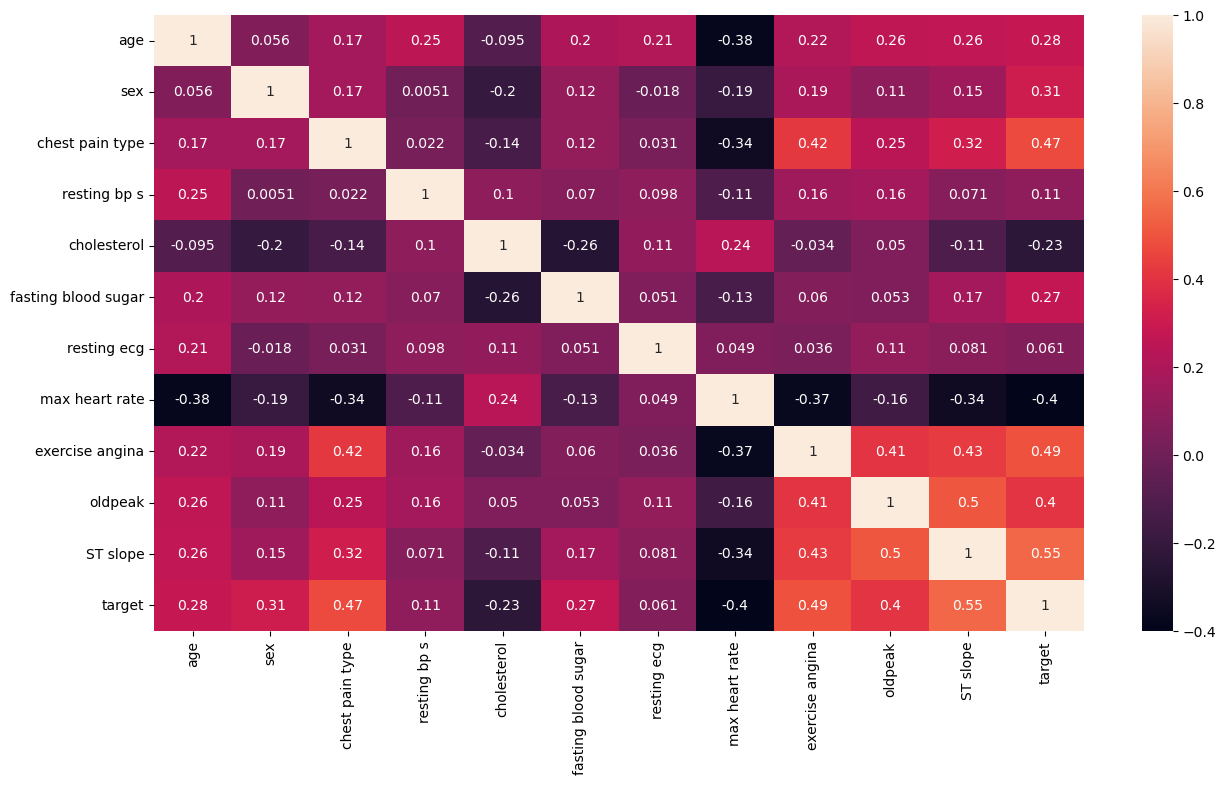

In [16]:
relations = df.corr()
plt.figure(figsize=(15,8))
sns.heatmap(data=relations, annot=True)